# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 1.0, 'Parameters / Coefficients')

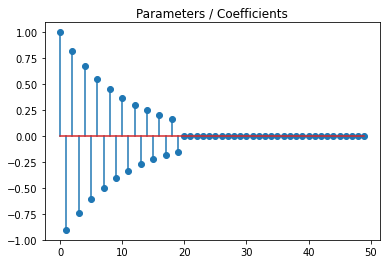

In [ ]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [ ]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [ ]:
A, b = simu_linreg(coefs)
#A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression
n= np.shape(A)[0]

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [ ]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    def soft_thresh(v):
      if v>lmbd:
        return(v-lmbd)
      elif v<-lmbd:
        return(v+lmbd)
      else:
        return(0)
    return np.array([soft_thresh(xi) for xi in x]) # TODO
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.sum(np.abs(x[i]) for i in range(x.shape[0])) # TODO

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""   
    return x / (lmbd+1) # TODO
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return lmbd *0.5* np.sum(np.square(x)) # TODO

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This signific

(-2.0, 2.0)

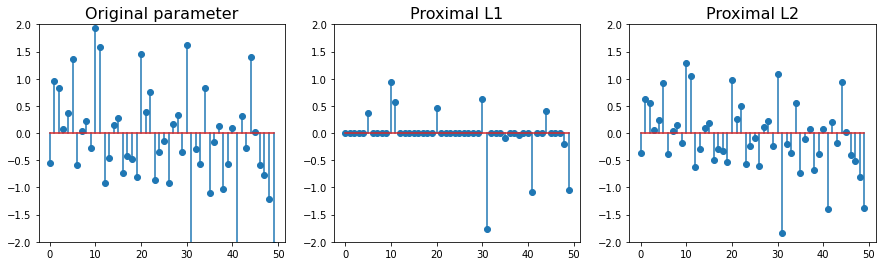

In [ ]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

- **Answer:** <br>
Comparing the two left figures with the right one (the one with original data) we can observe that the L1 operator is more dense than L2 (More coefficients were reduced to zero). Also, with the L2 norm we remark that the parameters were shrinked. (mainly due to the division by (1+lmbd))

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [ ]:
def loss_linreg(x):
    """Least-squares loss"""
    # TODO
    return 0.5* (1/n)* (np.sum((b - A @ x)**2))

def grad_linreg(x):
    """Least-squares gradient"""
    # TODO
    return (1/n) * A.T @ (A @ x - b)

def loss_logreg(x):
    """Logistic loss"""
    # TODO
    return (1/n) * np.sum([np.log(1+np.exp(-b[i]*A[i].T @ x)) for i in range(n)])

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    return (1/n)*np.sum((-b[i]*(A[i, :]).T*np.exp(-b[i]*np.dot((A[i, :]).T, x)))/(1 + np.exp(-b[i]*np.dot((A[i, :]).T, x))) for i in range(n))

# TO BE COMPLETED

In [ ]:
from scipy.optimize import check_grad
print("check grad for linear regression= " , check_grad(loss_linreg, grad_linreg, x))
print("check grad for logistic regression= " , check_grad(loss_logreg, grad_logreg, x))

check grad for linear regression=  1.0579067544676285e-06
check grad for logistic regression=  2.720124227699266e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [ ]:
# TO BE COMPLETED
# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    # TODO
    return ( np.linalg.norm(A,ord=2)**2/A.shape[0]) 
# Calculate the smoothness constant for Logistic loss + L2 regularizor    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    return np.linalg.norm(A,ord=2)**2/(4*A.shape[0])
    

def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        x_new = prox_R(x - step* grad_f(x), step*lmbd)
        x = x_new


        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [ ]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
  
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####
        t_new = 0.5 * (1 + np.sqrt(1+4*t**2))
        x_new = prox_R(z - step *grad_f(z), step*lmbd)
        z= x_new + (t-1)/t_new *(x_new - x)
        x= x_new
        t= t_new

        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [ ]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters given above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [ ]:
A, b = simu_linreg(coefs)
L = smoothness_const_linreg(A)
step = 1/L

In [ ]:
#Computing a local minimum and a local minimizer of linear regression:
x_min, loss_min, error_m = APGD(x0, loss_linreg, grad_linreg, L2_norm,prox_L2,step,lmbd, 1000, coefs, True)
local_minimum = loss_min[np.argmin(loss_min)]
local_minimizer = x_min 

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.25e+00 | 8.89e-01
      10 | 4.99e-01 | 1.36e-01
      20 | 4.99e-01 | 1.32e-01
      30 | 4.99e-01 | 1.31e-01
      40 | 4.99e-01 | 1.32e-01
      50 | 4.99e-01 | 1.31e-01
      60 | 4.99e-01 | 1.31e-01
      70 | 4.99e-01 | 1.31e-01
      80 | 4.99e-01 | 1.31e-01
      90 | 4.99e-01 | 1.31e-01
     100 | 4.99e-01 | 1.31e-01
     110 | 4.99e-01 | 1.31e-01
     120 | 4.99e-01 | 1.31e-01
     130 | 4.99e-01 | 1.31e-01
     140 | 4.99e-01 | 1.31e-01
     150 | 4.99e-01 | 1.31e-01
     160 | 4.99e-01 | 1.31e-01
     170 | 4.99e-01 | 1.31e-01
     180 | 4.99e-01 | 1.31e-01
     190 | 4.99e-01 | 1.31e-01
     200 | 4.99e-01 | 1.31e-01
     210 | 4.99e-01 | 1.31e-01
     220 | 4.99e-01 | 1.31e-01
     230 | 4.99e-01 | 1.31e-01
     240 | 4.99e-01 | 1.31e-01
     250 | 4.99e-01 | 1.31e-01
     260 | 4.99e-01 | 1.31e-01
     270 | 4.99e-01 | 1.31e-01
     280 | 4.99e-01 | 1.31e-01
     290 | 4.99e-01 | 1.31e-01
     300 | 4.99

In [ ]:
x_pgd, loss_pgd, error_pgd = PGD(x0, loss_linreg, grad_linreg, L2_norm,prox_L2,step,lmbd, n_iter, coefs, True)

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 1.25e+00 | 8.89e-01
      10 | 5.68e-01 | 3.43e-01
      20 | 5.06e-01 | 1.90e-01
      30 | 4.99e-01 | 1.49e-01
      40 | 4.99e-01 | 1.37e-01
      50 | 4.99e-01 | 1.33e-01
      60 | 4.99e-01 | 1.32e-01
      70 | 4.99e-01 | 1.32e-01
      80 | 4.99e-01 | 1.32e-01
      90 | 4.99e-01 | 1.31e-01
     100 | 4.99e-01 | 1.31e-01
     110 | 4.99e-01 | 1.31e-01
     120 | 4.99e-01 | 1.31e-01
     130 | 4.99e-01 | 1.31e-01
     140 | 4.99e-01 | 1.31e-01
     150 | 4.99e-01 | 1.31e-01
     160 | 4.99e-01 | 1.31e-01
     170 | 4.99e-01 | 1.31e-01
     180 | 4.99e-01 | 1.31e-01
     190 | 4.99e-01 | 1.31e-01
     200 | 4.99e-01 | 1.31e-01


In [ ]:
x_apgd, loss_apgd, error_apgd = APGD(x0, loss_linreg, grad_linreg, L2_norm,prox_L2,step,lmbd, n_iter, coefs, True)

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.25e+00 | 8.89e-01
      10 | 4.99e-01 | 1.36e-01
      20 | 4.99e-01 | 1.32e-01
      30 | 4.99e-01 | 1.31e-01
      40 | 4.99e-01 | 1.32e-01
      50 | 4.99e-01 | 1.31e-01
      60 | 4.99e-01 | 1.31e-01
      70 | 4.99e-01 | 1.31e-01
      80 | 4.99e-01 | 1.31e-01
      90 | 4.99e-01 | 1.31e-01
     100 | 4.99e-01 | 1.31e-01
     110 | 4.99e-01 | 1.31e-01
     120 | 4.99e-01 | 1.31e-01
     130 | 4.99e-01 | 1.31e-01
     140 | 4.99e-01 | 1.31e-01
     150 | 4.99e-01 | 1.31e-01
     160 | 4.99e-01 | 1.31e-01
     170 | 4.99e-01 | 1.31e-01
     180 | 4.99e-01 | 1.31e-01
     190 | 4.99e-01 | 1.31e-01
     200 | 4.99e-01 | 1.31e-01


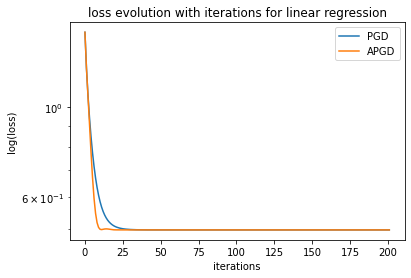

In [ ]:
plt.figure()
plt.plot(range(len(loss_pgd)),loss_pgd,label='PGD')
plt.plot(range(len(loss_apgd)),loss_apgd,label='APGD')
plt.title('loss evolution with iterations for linear regression')
plt.yscale('log')
plt.ylabel('log(loss)')
plt.xlabel('iterations')
plt.legend()
plt.show()

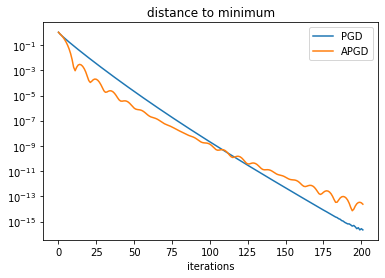

In [ ]:
#Distance to minimum:
plt.figure()
plt.plot(loss_pgd - local_minimum ,label='PGD')
plt.plot(loss_apgd - local_minimum,label='APGD')
plt.title('distance to minimum')
plt.yscale('log')
plt.xlabel('iterations')
plt.legend()
plt.show()

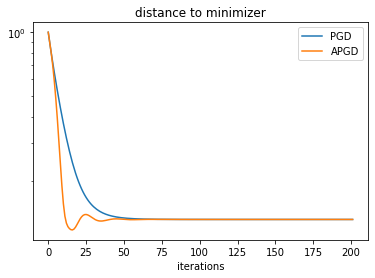

In [ ]:
#Distance to minimizer:
plt.figure()
plt.plot(error_pgd,label='PGD')
plt.plot(error_apgd, label='APGD')
plt.title('distance to minimizer')
plt.yscale('log')
plt.xlabel('iterations')
plt.legend()
plt.show()

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

In [ ]:
# PGD solution for linear regression with L1 regularization
x_pgd_L1, loss_pgd_L1, error_pgd_L1 = PGD(x0, loss_linreg, grad_linreg, L1_norm,prox_L1,step,lmbd, n_iter, coefs, False)
# APGD solution for linear regression with L1 regularization
x_apgd_L1, loss_apgd_L1, error_apgd_L1 = APGD(x0, loss_linreg, grad_linreg, L1_norm,prox_L1,step,lmbd, n_iter, coefs, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


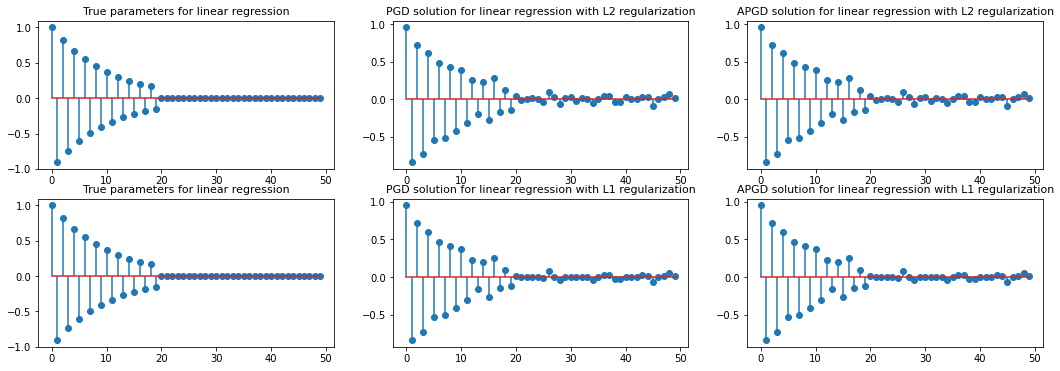

In [ ]:
# Comparing the solutions obtained with PGD and APGD with the true parameters
plt.figure(figsize=(18, 6))
plt.subplot(2, 3, 1)
plt.stem(coefs,use_line_collection=True)
plt.title("True parameters for linear regression",fontsize=11)
plt.subplot(2, 3, 2)
plt.stem(x_pgd,use_line_collection=True)
plt.title("PGD solution for linear regression with L2 regularization",fontsize=11)
plt.subplot(2, 3, 3)
plt.stem(x_apgd,use_line_collection=True)
plt.title("APGD solution for linear regression with L2 regularization",fontsize=11)

plt.subplot(2, 3, 4)
plt.stem(coefs,use_line_collection=True)
plt.title("True parameters for linear regression",fontsize=11)
plt.subplot(2, 3, 5)
plt.stem(x_pgd_L1,use_line_collection=True)
plt.title("PGD solution for linear regression with L1 regularization",fontsize=11)
plt.subplot(2, 3, 6)
plt.stem(x_apgd_L1,use_line_collection=True)
plt.title("APGD solution for linear regression with L1 regularization",fontsize=11)
plt.show()

> - **Comments:** <br>
We notice that the solutions given by PGD and APGD are very close and represent **good estimators of the true parameters** especially in the case of L1 regularization where some coefficients in the solutions given by both algorithms are exactely equal to zero just like the true parameters.

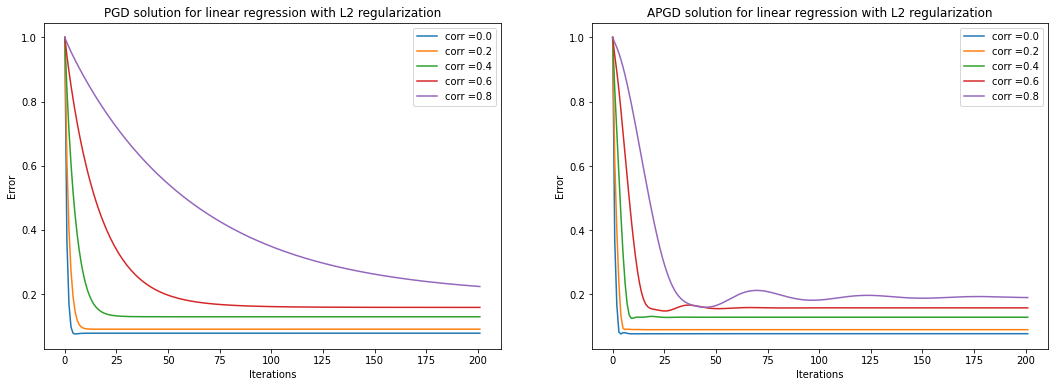

In [ ]:
# Influence of the correlation of the features on the performance of the optimization algorithm in case of linear regression with L2 regularization
list_corr = np.arange(0, 1, 0.2)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6))

for c in list_corr :
  A,b=simu_linreg(coefs,corr=c)
  L = smoothness_const_linreg(A)
  step = 1/L
  x_pgd, loss_pgd, error_pgd = PGD(x0, loss_linreg, grad_linreg, L2_norm,prox_L2,step,lmbd, n_iter, coefs, False)
  x_apgd, loss_apgd, error_apgd = APGD(x0, loss_linreg, grad_linreg, L2_norm,prox_L2,step,lmbd, n_iter, coefs, False)

  # Plotting the solutions
  ax1.plot(error_pgd, label=f'corr ={round(c,1)}')
  ax1.set_title("PGD solution for linear regression with L2 regularization")
  ax1.set_xlabel("Iterations")
  ax1.set_ylabel("Error")
  ax1.legend()

  ax2.plot(error_apgd, label=f'corr ={round(c,1)}')
  ax2.set_title("APGD solution for linear regression with L2 regularization")
  ax2.set_xlabel("Iterations")
  ax2.set_ylabel("Error")
  ax2.legend()

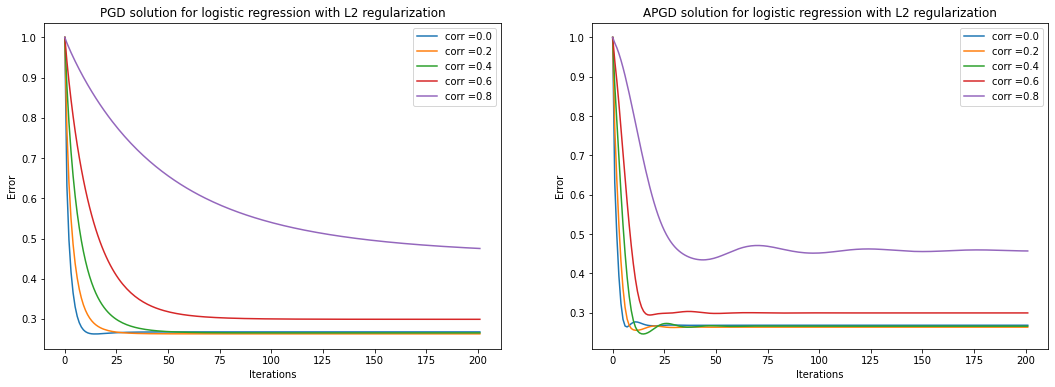

In [ ]:
# Influence of the correlation of the features on the performance of the optimization algorithm in case of linear regression with L2 regularization
list_corr = np.arange(0, 1, 0.2)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6))

for c in list_corr :
  A,b=simu_logreg(coefs,corr=c)
  L = smoothness_const_loreg(A)
  step = 1/L
  x_pgd, loss_pgd, error_pgd = PGD(x0, loss_logreg, grad_logreg, L2_norm,prox_L2,step,lmbd, n_iter, coefs, False)
  x_apgd, loss_apgd, error_apgd = APGD(x0, loss_logreg, grad_logreg, L2_norm,prox_L2,step,lmbd, n_iter, coefs, False)

  # Plotting the solutions
  ax1.plot(error_pgd, label=f'corr ={round(c,1)}')
  ax1.set_title("PGD solution for logistic regression with L2 regularization")
  ax1.set_xlabel("Iterations")
  ax1.set_ylabel("Error")
  ax1.legend()

  ax2.plot(error_apgd, label=f'corr ={round(c,1)}')
  ax2.set_title("APGD solution for logistic regression with L2 regularization")
  ax2.set_xlabel("Iterations")
  ax2.set_ylabel("Error")
  ax2.legend()

> - **Comments:** <br>
We notice that as the correlation increases, the convergence for both algorithms becomes slower. So the smaller the correlation value, the better the performance. The reason behind this is that the step which is the inverse of the smoothness constant increases when the correlation value decreases and this leads to a faster convergence.<br>
We can clearly see that APGD converges faster than the PGD for all correlation values. So it gives better performances than the PGD.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/l

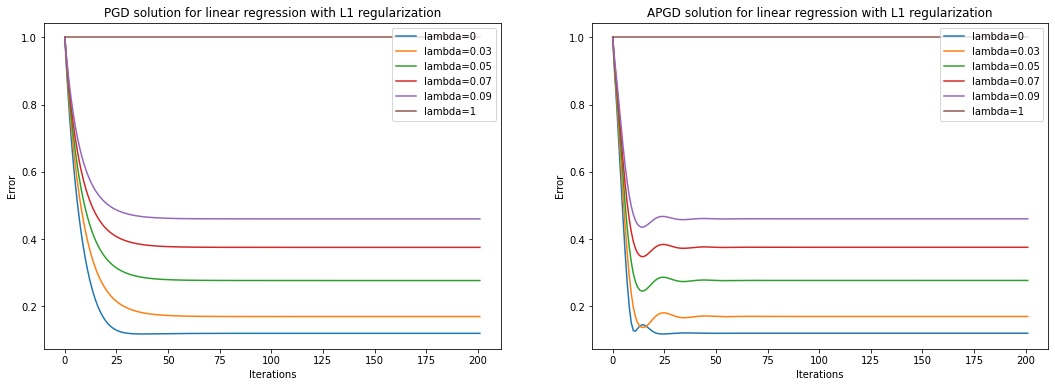

In [ ]:
# Influence of the level of penalization ( λ ) on the performance of the optimization algorithms
list_lmbd = [0,0.03,0.05,0.07,0.09,1]
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6))

A,b=simu_linreg(coefs,corr=0.5)
L = smoothness_const_linreg(A)
step = 1/L
for lmbd in list_lmbd :
  x_pgd, loss_pgd, error_pgd = PGD(x0, loss_linreg, grad_linreg, L1_norm,prox_L1,step,lmbd, n_iter, coefs, False)
  x_apgd, loss_apgd, error_apgd = APGD(x0, loss_linreg, grad_linreg, L1_norm,prox_L1,step,lmbd, n_iter, coefs, False)

  # Plotting the solutions
  ax1.plot(error_pgd, label=f'lambda={lmbd}')
  ax1.set_title("PGD solution for linear regression with L1 regularization")
  ax1.set_xlabel("Iterations")
  ax1.set_ylabel("Error")
  ax1.legend()

  ax2.plot(error_apgd, label=f'lambda={lmbd}')
  ax2.set_title("APGD solution for linear regression with L1 regularization")
  ax2.set_xlabel("Iterations")
  ax2.set_ylabel("Error")
  ax2.legend()

> - **Comments:** <br>
We notice that the more the penalization parameter increases, the more the error rate increases. In fact, since when $\lambda$ increases we penalize more coefficients which means that less coefficients will be used (in case of L1 regularization the more $\lambda$ increases the more the solution is sparse) this is leads to a higher error rate. We can clearly see that APGD converges faster than PGD whatever is the value of the regularization parameter.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  


Text(0, 0.5, 'Parameters')

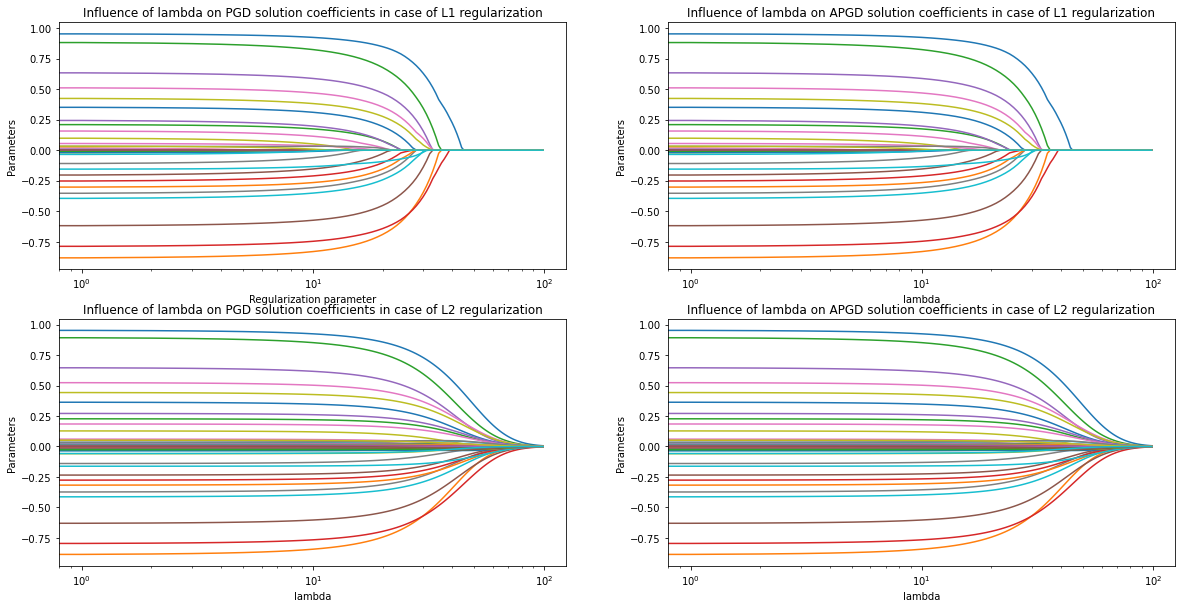

In [ ]:
# Analysing the behaviour of the solution vector when lambda increases
# We are going to plot the parameters in function of lambda for the problem of linear regression with the two different regularizations
fig, axs = plt.subplots(2, 2, figsize=(20,10))
plt.title('Linear Regression problem', fontsize=15)
A,b=simu_linreg(coefs,corr=0.5)
L = smoothness_const_linreg(A)
step = 1/L
list_lambda=np.logspace(-2,2,100)
parameters_pgd_L1, parameters_apgd_L1=[],[]
parameters_pgd_L2, parameters_apgd_L2=[],[]

for lmbd in list_lambda:
    x_pgd_L1,loss_pgd_L1, error_pgd_L1= PGD(x0, loss_linreg, grad_linreg, L1_norm,prox_L1,step,lmbd, n_iter, coefs, False)
    x_apgd_L1, loss_apgd_L1, error_apgd_L1 = APGD(x0, loss_linreg, grad_linreg, L1_norm,prox_L1,step,lmbd, n_iter, coefs, False)
    x_pgd_L2,loss_pgd_L2, error_pgd_L2 = PGD(x0, loss_linreg, grad_linreg, L2_norm,prox_L2,step,lmbd, n_iter, coefs, False)
    x_apgd_L2, loss_apgd_L2, error_apgd_L2 = APGD(x0, loss_linreg, grad_linreg, L2_norm,prox_L2,step,lmbd, n_iter, coefs, False)

    parameters_pgd_L1.append(x_pgd_L1)
    parameters_apgd_L1.append(x_apgd_L1)
    parameters_pgd_L2.append(x_pgd_L2)
    parameters_apgd_L2.append(x_apgd_L2)

axs[0][0].plot(np.vstack(parameters_pgd_L1))
axs[0][0].set_xscale('log')
axs[0][0].set_title('Influence of lambda on PGD solution coefficients in case of L1 regularization',fontsize=12)
axs[0][0].set_xlabel('Regularization parameter')
axs[0][0].set_ylabel('Parameters')

axs[0][1].plot(np.vstack(parameters_apgd_L1))
axs[0][1].set_xscale('log')
axs[0][1].set_title('Influence of lambda on APGD solution coefficients in case of L1 regularization',fontsize=12)
axs[0][1].set_xlabel('lambda')
axs[0][1].set_ylabel('Parameters')

axs[1][0].plot(np.vstack(parameters_pgd_L2))
axs[1][0].set_xscale('log')
axs[1][0].set_title('Influence of lambda on PGD solution coefficients in case of L2 regularization',fontsize=12)
axs[1][0].set_xlabel('lambda')
axs[1][0].set_ylabel('Parameters')

axs[1][1].plot(np.vstack(parameters_apgd_L2))
axs[1][1].set_xscale('log')
axs[1][1].set_title('Influence of lambda on APGD solution coefficients in case of L2 regularization', fontsize=12)
axs[1][1].set_xlabel('lambda')
axs[1][1].set_ylabel('Parameters')


> **Comments:**
- For the L1 regularization, we notice that as $\lambda$ increases, the coefficients becomes equal to zero pregressively (one after the other not at the same value of $\lambda$) which means that the more $\lambda$ increases the solution becomes more sparse until it will be a null vector when $\lambda$ is very high.So the L1 regularization can be used for feature selection since for a chosen value of $\lambda$ we have a sparse solution that contains non null values for important features.
- For L2 regularization, we notice that when $\lambda$ increases the coefficients becomes more and more small until they will be equal to zero for the same value of $\lambda$ which is a high value. <br>
$\Longrightarrow$ So L2 regularization is used in order to shrink the coefficients (makes them smaller) while the L1 regularization is used in order to have sparse solution.
